<a href="https://colab.research.google.com/github/isaacyeSN/SS2021/blob/main/Day2AM/SS21_lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Classification (MNIST)**

### **1) MLP model**

# 0. Import necessary modules

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torch.optim as optim
from sklearn.metrics import accuracy_score
import numpy as np
import argparse
import time

# 1. Data Preparation

The **MNIST** database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.

We split the training set into 50k and 10k of training and validation data sets.

**Data Set**  
$$X_{train} \in \mathcal{R}^{50000 \times 784}, Y_{train} \in \mathcal{Z}^{50000}$$  
$$X_{val} \in \mathcal{R}^{10000 \times 784}, Y_{val} \in \mathcal{Z}^{10000}$$  
$$X_{test} \in \mathcal{R}^{10000 \times 784}, Y_{test} \in \mathcal{Z}^{10000}$$

### Data loading using dataloader

In [ ]:
batch_size = 128
train_dataset = datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_dataset =  datasets.MNIST('./data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])
print(len(train_dataset), len(val_dataset), len(test_dataset))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!
50000 10000 10000


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Inspecting Dataset

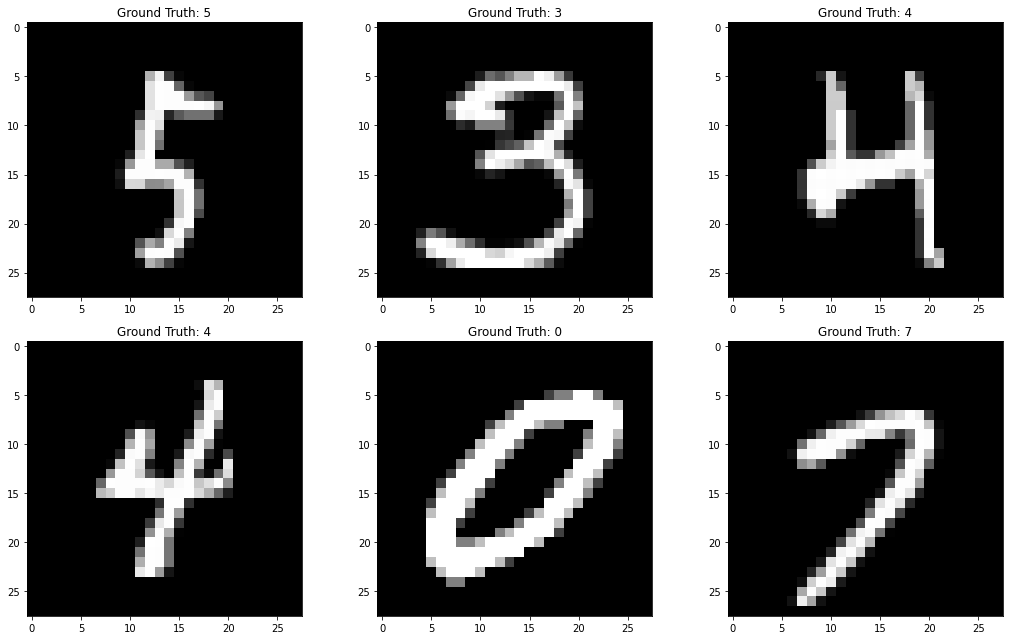

In [ ]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)  

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 9))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
plt.show()

# 2. Model Define

### **Linear model**

In [ ]:
class LinearModel(nn.Module):
    def __init__(self): 
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=784, out_features=10, bias=True)
    
    def forward(self, x):
        x = self.linear(x)
        return x

### **MLP model**

In [ ]:
class MLPModel(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layers, act, dropout, use_bn, use_xavier): 
        super(MLPModel, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.act = act
        self.dropout = dropout
        self.use_bn = use_bn
        self.use_xavier = use_xavier

        self.fc = nn.Linear(self.in_dim, self.hid_dim)

        self.linears = nn.ModuleList()
        self.bns = nn.ModuleList()
        for i in range(self.n_layers-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
            if self.use_bn:
                self.bns.append(nn.BatchNorm1d(self.hid_dim))
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)

        if self.act == 'relu':
            self.act = nn.ReLU()
        
        self.dropout = nn.Dropout(self.dropout)
        if self.use_xavier:
            for linear in self.linears:
                nn.init.xavier_normal_(linear.weight)
                linear.bias.data.fill_(0.01)
    
    def forward(self, x):
        x = self.act(self.fc(x))
        for i in range(len(self.linears)):
            x = self.act(self.linears[i](x))
            x = self.bns[i](x)
            x = self.dropout(x)
        x = self.fc2(x)
        return x

# 3. Simulation Define

In [ ]:
def experiment(args):
    model = MLPModel(args.in_dim, args.out_dim, args.hid_dim, args.n_layers, args.act, args.dropout, args.use_bn, args.use_xavier)

    print(model)

    # ====== Loss function ====== #
    #criterion = nn.MSELoss()
    criterion = nn.CrossEntropyLoss() #Image classification

    optimizer = optim.SGD(model.parameters(), lr=args.lr)

    # ====== Data collection ====== #
    list_epoch = [] 
    list_train_loss = []
    list_val_loss = []
    list_acc = []
    list_acc_epoch = []

    # ====== Loop ====== #
    for epoch in range(args.epoch):  
        
        # ====== Train ====== #
        model.train() # Set the model be 'train mode' 
        train_loss = 0 # to sum up each batch
        
        for input_X, true_y in train_loader:
            optimizer.zero_grad() # Initialize the gradient in the optimizer

            input_X = input_X.squeeze()
            input_X = input_X.view(-1, 784)

            pred_y = model(input_X)

            loss = criterion(pred_y.squeeze(), true_y)
            loss.backward()
            optimizer.step()
            train_loss +=loss.item()

        train_loss = train_loss / len(train_loader)
        list_train_loss.append(train_loss)
        list_epoch.append(epoch)

        # ====== Validation ====== #
        model.eval() # Set the model be 'train mode' 
        val_loss = 0 # to sum up each batch
        
        with torch.no_grad():
            for input_X, true_y in val_loader:

                input_X = input_X.squeeze()
                input_X = input_X.view(-1, 784)

                pred_y = model(input_X)

                loss = criterion(pred_y.squeeze(), true_y)
                val_loss += loss.item()

        val_loss = val_loss / len(val_loader)
        list_val_loss.append(val_loss)

        # ====== Evaluation ====== #
        model.eval() # Set the model be 'train mode' 
        correct = 0 # to sum up each batch
        
        with torch.no_grad():
            for input_X, true_y in test_loader:

                input_X = input_X.squeeze()
                input_X = input_X.view(-1, 784)

                pred_y = model(input_X).max(1, keepdim=True)[1].squeeze()
                correct += pred_y.eq(true_y).sum()

            acc = correct.item() / len(test_loader.dataset)
            list_acc.append(acc)
            list_acc_epoch.append(epoch)
        
        print('Epoch: {}, Train Loss: {}, Val Loss: {}, Test Acc: {}%'.format(epoch, train_loss, val_loss, acc*100))

    return list_epoch, list_train_loss, list_val_loss, list_acc, list_acc_epoch

# 4. Train & Evaluation

### Checking GPU availability

In [ ]:
ts = time.time()

seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()

args = parser.parse_args("")

args.in_dim = 2
args.out_dim = 1
args.hid_dim = 200
args.n_layers = 5
args.act = 'relu'
args.dropout = 0.1
args.use_bn = 'True'
args.use_xavier = 'True'

args.lr = 0.005
args.epoch = 5000

list_epoch, list_train_loss, list_val_loss, list_acc, list_acc_epoch = experiment(args)

te = time.time()

print('Elapsed time: {} sec'.format(int(te-ts)))

MLPModel(
  (fc): Linear(in_features=2, out_features=200, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=200, out_features=200, bias=True)
    (1): Linear(in_features=200, out_features=200, bias=True)
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Linear(in_features=200, out_features=200, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc2): Linear(in_features=200, out_features=1, bias=True)
  (act): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)


RuntimeError: ignored

# 5. Report

In [ ]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.set_ylim(0, 5)
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_acc_epoch, list_acc, marker='x', label='mae metric')

ax2.set_xlabel('epoch')
ax2.set_ylabel('mae')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs mae')


plt.show()